<a href="https://colab.research.google.com/github/scline6/MachineTriangulation/blob/master/MachineTriangulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OVERVIEW

*   This project is about using machine learning to make Constrained Delaunay Triangulations (CDT) of 2D polygons.
*   This came to my mind as a good way to learn about Neural Network Architectures.  The input polygon contour is ordered and circular (i.e. last comes before first).  The output is an array of vertices where index i is the third point of a triangle together with input indices i and i+1, and so on.  This method omits some triangles of the CDT, which is a minor downside.  However, it has the big advantage of providing a canonical order to the output, which should make it easier for the neural network to learn.
*   I started by writing Triangulator, a C++ header-only library for making Constrained Delaunay Triangulations of 2D polygons.  It is based on ear-clipping and Delaunay-Lawson flips.  The ear-clipping part has a novel priority queue, which greedily selects high quality triangles, thus reducing the number of Delaunay-Lawson flips needed in the second stage.
*   Training, Test, and Validation datasets (sized to 50000, 15000, and 5000 respectively) were generated by running triangulator on randomly generated polygons.  To start, all polygons have exactly 8 vertices.  The eventual goal is to find a good representation for handling variable-length polygons with 8 to 16 vertices.



STEP #1: AUTOMATIC GENERATION OF DATASET
1.   Run the generateDeepLearningDataset function from the C++ project.  On my computer, the below command works.  You will need to set up your own folder structure and call the function with similar arguments.
2.   The generateDeepLearningDataset function call will generate files named Train_Triangulations.csv, Test_Triangulations.csv, and Val_Triangulations.csv, which contain both the input polygon data and output triangulation data.  
3.   Optionally, the generateDeepLearningDataset call can generate an image file for each triangulation case (70000 in total).  This is for visual debugging purposes.  The images can stay on your local computer and there is no reason to upload them to Colab.



In [ ]:
"""
int result = TriangulatorTest::generateDeepLearningDataset("/home/shane/Documents/TensorFlow/Triangulator/TrainingData/Training/", 
                                                           50000, 15000, 5000);
"""

'\nint result = TriangulatorTest::generateDeepLearningDataset("/home/shane/Documents/TensorFlow/Triangulator/TrainingData/Training/", \n                                                           50000, 15000, 5000);\n'

STEP #2: LOAD DATASET - PART A

Run the following python script to load the dataset from your Google Drive.

After loading, the dataset will be stored in a TriangulationData class object named "data". The rest of this session will reference the "data" object. The important members of the TriangulationData class are x_train, y_train, x_test, y_test, x_val, and y_val.


In [1]:
# Import matplotlib for plotting (inline, not a separate window)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import math and matrix libraries
import math
import numpy as np
from sklearn.metrics import confusion_matrix

# Import tensorflow and keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input, Dropout
from tensorflow.keras.layers import Reshape, MaxPooling1D, MaxPool1D
from tensorflow.keras.layers import Dense, Conv1D, SimpleRNN, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.models import Model
print("Tensorflow Version: ",tf.__version__)    # Double-check the Tensorflow version

# Import os and zip utility libraries
import os
import tarfile
import ntpath
from google.colab import files, drive

# Filenames for the data-set
filename_train = "Train_Triangulations.csv"
filename_test  = "Test_Triangulations.csv"
filename_val   = "Val_Triangulations.csv"

# A python class to hold the entire dataset (inputs & outputs x training, test & validation)
class TriangulationData:

    def load_datasubset(self, csvfilename, num_vertices):
        fin = open(csvfilename, "r")
        lines = fin.readlines()
        fin.close()
        M = len(lines)    # Number of triangulations in subset (usually 50000, 15000, 5000)
        N = 2 * num_vertices
        x_train = np.zeros( (M, N), dtype=float)
        y_train = np.zeros( (M, N), dtype=float)
        for i in range(0, M):
            entries = lines[i].split(",")
            for j in range(0, N):
                x_train[i,j] = float(entries[j])
                y_train[i,j] = float(entries[N + j])
        return (x_train, y_train)

    def __init__(self, num_vertices):
        self.num_vertices = num_vertices
        self.num_coordinates = 2 * num_vertices
        (self.x_train, self.y_train) = self.load_datasubset(filename_train, num_vertices)
        (self.x_test,  self.y_test ) = self.load_datasubset(filename_test,  num_vertices)
        (self.x_val,   self.y_val  ) = self.load_datasubset(filename_val,   num_vertices)

    def random_batch(self, batch_size):
        indices = np.random.randint(low=0, high=self.num_train, size=batch_size) 
        return self.x_train[indices], self.y_train[indices]

drive.mount("/content/gdrive")
os.chdir("/content/gdrive/My Drive/Triangulation_Dataset1")
data = TriangulationData(8)

Tensorflow Version:  2.3.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


STEP #2: DATASET LOADING - PART B

Plot a few polygons and their triangulations to make sure the data is correct.

They look correct.  The missing triangles are expected.  My approach keeps only triangles that have one edge on the original polygon contour.  This helps to establish a canonical order for the triangles as opposed to random order, which would presumably be harder for the neural network to learn.



TRAIN:



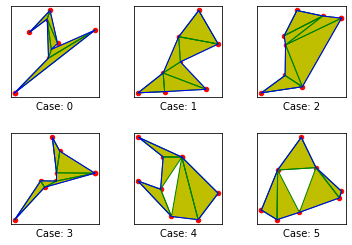



TEST:



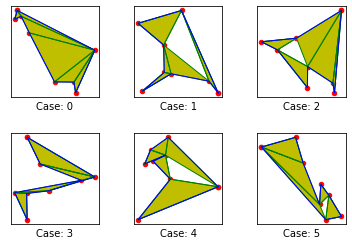



VAL:



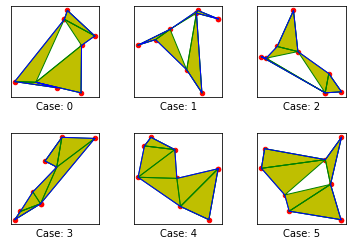

In [2]:
def plot_triangulation(M, N, x, y, subset, offset=0):
    if subset != "": print("\n\n" + subset + ":\n")
    polygon_size = 8
    x_indices = list(map(lambda a: a*2, range(0, polygon_size))) + [0]
    y_indices = list(map(lambda a: a+1, x_indices))
    fig, axes = plt.subplots(M, N)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])
        s = 1;
        for j in range(0, polygon_size):
            xx = [x[offset+i,2*j], x[offset+i,2*((j+1)%polygon_size)], y[offset+i,2*j], x[offset+i,2*j]]
            yy = [x[offset+i,2*j+1], x[offset+i,2*((j+1)%polygon_size)+1], y[offset+i,2*j+1], x[offset+i,2*j+1]]
            ax.plot(xx, yy, color='g', linewidth=1)
            ax.fill(xx, yy, "y")
        ax.plot(x[offset+i,x_indices], x[offset+i,y_indices], color='b', linewidth=1)
        ax.scatter(x[offset+i,x_indices], x[offset+i,y_indices], color='r', s=20)
        xlabel = "Case: {0}".format(i)
        ax.set_xlabel(xlabel)
    plt.show()

plot_triangulation(2, 3, data.x_train, data.y_train, "TRAIN")
plot_triangulation(2, 3, data.x_test,  data.y_test , "TEST" )
plot_triangulation(2, 3, data.x_val,   data.y_val  , "VAL"  )

STEP #3: MODEL DEFINITION

Build the model layers using Keras functional API in Tensorflow2.

This is still a work-in-progress.  So far, dense networks are performing the best.  That said, it is still not learning to avoid intersections.  It seems like max-pooling could help, but I have not found the right architecture to get any gain out of it yet.

In [3]:
"""
model = Sequential([
    Dense(data.num_coordinates * 16, activation='relu'),
    Dropout(0.05),
    Dense(data.num_coordinates * 256, activation='relu'),
    Dropout(0.15),
    Dense(data.num_coordinates * 256, activation='relu'),
    Dropout(0.15),
    #Reshape((256, data.num_coordinates)),
    #MaxPool1D(pool_size=256),
    #Flatten(),
    Dense(data.num_coordinates * 16, activation='relu'),
    Dropout(0.05),
    Dense(data.num_coordinates),
])
"""

model = Sequential([         
    Dense(data.num_coordinates *  16, activation='relu'),
    Dropout(0.1),  
    Dense(data.num_coordinates * 256, activation='relu'),
    Dropout(0.3),
    Dense(data.num_coordinates * 256, activation='relu'),
    Dropout(0.3),
    Dense(data.num_coordinates *  64, activation='relu'),
    Dropout(0.2),
    Dense(data.num_coordinates *  16, activation='relu'),
    Dropout(0.1),  
    Dense(data.num_coordinates *   4, activation='relu'),  
    Dense(data.num_coordinates),
])


STEP #4a: TRAINING

Compile the model, fit it to the training data, and evaluate it on test data.

There is a bit a hands-on play to pick good learning_rate and num_epochs.  Future work should focus on a custom loss function that will help the model learn to avoid intersections.



In [35]:
########## Settings that you can change ##########
optimizer_type = "ADAM"  #"ADAM" or "RMSPROP"
learning_rate  = 0.001
num_epochs     = 25
batch_size     = 128
##################################################

optimizer = None
if optimizer_type == "ADAM":
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer_type == "RMSPROP":
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

loss = tf.keras.losses.MeanAbsoluteError()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

model.compile(optimizer=optimizer, loss=loss, loss_weights=1.0, metrics=metrics)

print("\nFITTING: ", data.x_train.shape, " | ", data.y_train.shape)
model.fit(x=data.x_train, y=data.y_train, epochs=num_epochs, batch_size=batch_size, verbose=1)

print("\nEVALUATING: ")
result = model.evaluate(x=data.x_test, y=data.y_test)
for name, value in zip(model.metrics_names, result):
    print(name, value)


FITTING:  (50000, 16)  |  (50000, 16)
Epoch 1/25
391/391 [==============================] - 3s 6ms/step - loss: 0.0711 - mean_absolute_error: 0.0711
Epoch 2/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0709 - mean_absolute_error: 0.0709
Epoch 3/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0709 - mean_absolute_error: 0.0709
Epoch 4/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0708 - mean_absolute_error: 0.0708
Epoch 5/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0705 - mean_absolute_error: 0.0705
Epoch 6/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0705 - mean_absolute_error: 0.0705
Epoch 7/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0706 - mean_absolute_error: 0.0706
Epoch 8/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0705 - mean_absolute_error: 0.0705
Epoch 9/25
391/391 [==============================] - 2s 6ms/step - loss:

STEP #4b: SAVE MODEL

Run this code snippet only if you want to save the model and weights.  Please comment it out after running.

In [ ]:
#model.save("/content/gdrive/My Drive/MachineTriangulation_Model_save_3.ckpt")
#model.save_weights("/content/gdrive/My Drive/MachineTriangulation_Model_save_weights_3.ckpt")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/MachineTriangulation_Model_save_1.ckpt/assets


STEP #4c: LOAD MODEL

Run this code snippet only if you want to load an old model.  Please comment it out after running.

In [39]:
#model = tf.keras.models.load_model("/content/gdrive/My Drive/MachineTriangulation_Model_save_2.ckpt")

STEP #5: DIAGNOSTICS

1.   The results are not great yet - only 20% success on entire triangulations, and 73% success on individual triangles.

2.   The model has not learned to avoid intersections.  In addition, the predicted triangulation sometimes leaves the bounds of the polygon contour.  Making the dense network wider and deeper has not helped to resolve these two issues.  Therefore, these two issues could be a hard limit that cannot be overcome with a simple MLP architecture.

3.   On the plus side, the model learned to pick an input vertex rather than generate any random x,y-pair in the output.

perfect_match=  20.653333333333336 %   |    partial_match=  73.6775 %


PREDICTED:



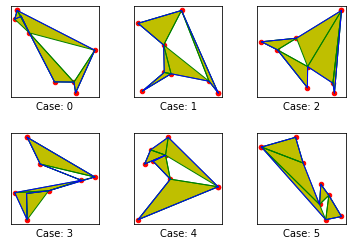



CORRECTED:



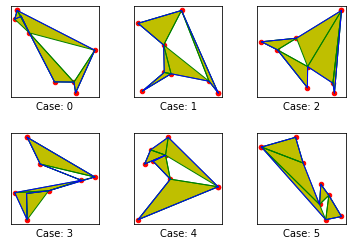



ABSOLUTE_TRUTH:



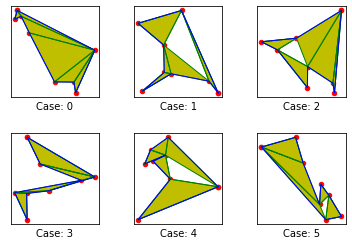

In [44]:
### Compute corrected prediction (the closest input vertex to the predicted point)
y_test_pred = model.predict(x=data.x_test)
y_test_pred_corr = y_test_pred
M = data.x_test.shape[0]
N = data.x_test.shape[1] // 2
for i in range(0, M):
    for j in range(0, N):
        x1 = y_test_pred[i,2*j]
        y1 = y_test_pred[i,2*j+1]
        min_dist = 999999999999999999.0
        x_closest = None
        y_closest = None
        for k in range(0, N):
            x2 = data.x_test[i,2*k]
            y2 = data.x_test[i,2*k+1]
            dist = (x2-x1)**2 + (y2-y1)**2
            if dist < min_dist:
                min_dist = dist
                x_closest = x2
                y_closest = y2
        y_test_pred_corr[i,2*j  ] = x_closest
        y_test_pred_corr[i,2*j+1] = y_closest

# Make a goodness-of-fit measure for the corrected prediction
EPSILON = 1e-6
count_perfect_match = 0
count_partial_match = 0
perfect_denom = 0
partial_denom = 0
for i in range(0, M):
    all_match = True
    for j in range(0, N):
        xpc = y_test_pred_corr[i,2*j  ]
        ypc = y_test_pred_corr[i,2*j+1]
        xtrue = data.y_test[i,2*j  ]
        ytrue = data.y_test[i,2*j+1]
        match = abs(xpc - xtrue) < EPSILON and abs(ypc - ytrue) < EPSILON
        if match:
            count_partial_match += 1
        else:
            all_match = False
    if all_match:
        count_perfect_match += 1
    partial_denom += N
    perfect_denom += 1
perfect_match = count_perfect_match / perfect_denom
partial_match = count_partial_match / partial_denom
print("perfect_match= ", perfect_match*100.0, "%   |   ", "partial_match= ", partial_match*100.0, "%")

### Plot the predicted triangulations and the true triangulations
plot_triangulation(2, 3, data.x_test, y_test_pred,      "PREDICTED")
plot_triangulation(2, 3, data.x_test, y_test_pred_corr, "CORRECTED")
plot_triangulation(2, 3, data.x_test, data.y_test,      "ABSOLUTE_TRUTH")